<a href="https://colab.research.google.com/github/khall02/DS4-PH-2025/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Connect to the SQLite database- uploaded opioid.db to google colab, saved from Terminal
conn = sqlite3.connect("/content/opioid.db")


In [ ]:
# Read tables into Pandas dataframes
county_pop_arcos = pd.read_sql_query("SELECT * FROM county_pop_arcos", conn)
land_area = pd.read_sql_query("SELECT * FROM land_area", conn)
county_annual = pd.read_sql_query("SELECT * FROM county_annual", conn)


In [ ]:
conn.close()


In [ ]:
# Look at data preview:
print(county_pop_arcos.head())
print(land_area.head())
print(county_annual.head())


   ? BUYER_COUNTY BUYER_STATE countyfips STATE COUNTY county_name  \
0  1      AUTAUGA          AL      01001     1      1     Autauga   
1  2      BALDWIN          AL      01003     1      3     Baldwin   
2  3      BARBOUR          AL      01005     1      5     Barbour   
3  4         BIBB          AL      01007     1      7        Bibb   
4  5       BLOUNT          AL      01009     1      9      Blount   

                      NAME    variable  year population  
0  Autauga County, Alabama  B01003_001  2006      51328  
1  Baldwin County, Alabama  B01003_001  2006     168121  
2  Barbour County, Alabama  B01003_001  2006      27861  
3     Bibb County, Alabama  B01003_001  2006      22099  
4   Blount County, Alabama  B01003_001  2006      55485  
   ?       Areaname  STCOU LND010190F  LND010190D LND010190N1 LND010190N2  \
0  1  UNITED STATES  00000          0  3787425.08        0000        0000   
1  2        ALABAMA  01000          0    52422.94        0000        0000   
2  3  

In [ ]:
# Rename columns for consistency
county_pop_arcos.rename(columns={ "BUYER_STATE": "state", "population": "pop"}, inplace=True)
county_annual.rename(columns={"BUYER_COUNTY": "county_name", "BUYER_STATE": "state", "DOSAGE_UNIT": "opioid_pills"}, inplace=True)
land_area.rename(columns={"STCOU": "countyfips"}, inplace=True)


In [ ]:
# Convert "NA" to NaN for missing countyfips values:
county_annual["countyfips"] = county_annual["countyfips"].replace("NA", pd.NA)


In [ ]:
# Fix Montg. County, AR
county_annual.loc[
    (county_annual["state"] == "AR") & (county_annual["county_name"] == "MONTGOMERY"),
    "countyfips"
] = "05097"

In [ ]:
# Drop rows where countyfips is still missing
county_annual = county_annual.dropna(subset=["countyfips"])


In [ ]:
# Convert countyfips to string for consistent merging
county_pop_arcos["countyfips"] = county_pop_arcos["countyfips"].astype(str)
county_annual["countyfips"] = county_annual["countyfips"].astype(str)


In [ ]:
# Select only the required columns from land_area
land_area = land_area[["Areaname", "countyfips", "LND110210D"]]



In [ ]:
# Convert countyfips in land_area to string
land_area["countyfips"] = land_area["countyfips"].astype(str)


In [ ]:
# Merge tables: population + land_area
county_info = county_pop_arcos.merge(land_area, on="countyfips", how="left")



In [ ]:
# Merge with annual opioid data
df = county_info.merge(county_annual, on=["countyfips", "year", "state"], how="left")


In [ ]:
# Convert year to integer
df["year"] = df["year"].astype(int)


In [ ]:
# Ensure numeric columns are properly formatted
df["opioid_pills"] = pd.to_numeric(df["opioid_pills"], errors="coerce")
df["pop"] = pd.to_numeric(df["pop"], errors="coerce")



In [ ]:
# Calculate opioid pills per person
df["opioid_pills_per_person"] = df["opioid_pills"] / df["pop"]


In [ ]:
# Aggregate: average opioid pills per year
opioid_by_year = df.groupby("year")["opioid_pills_per_person"].mean().reset_index()


In [ ]:
# Print preview
print(opioid_by_year.head())


   year  opioid_pills_per_person
0  2006                28.783799
1  2007                32.474087
2  2008                35.503895
3  2009                39.094975
4  2010                41.532509


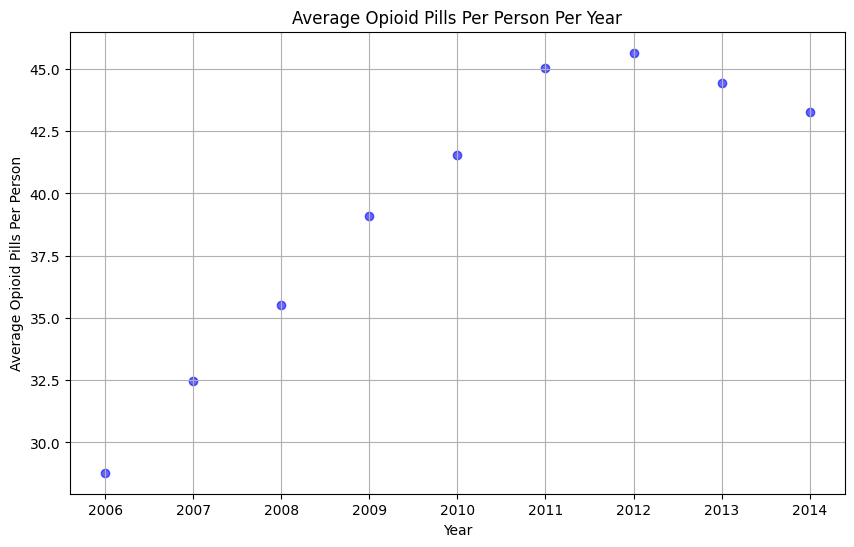

In [ ]:
#Create a scatterplot of the average number of opiod pills by year by loading the sql database in python
plt.figure(figsize=(10, 6))
plt.scatter(opioid_by_year["year"], opioid_by_year["opioid_pills_per_person"], color='b', alpha=0.6)
plt.xlabel("Year")
plt.ylabel("Average Opioid Pills Per Person")
plt.title("Average Opioid Pills Per Person Per Year")
plt.grid(True)
plt.show()

In [98]:
#Take your R code from the previous step and call it from python instead of R. Convert the resulting dataset to a pandas dataframe.


import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

In [99]:
# Initialize R <-> Python conversion
pandas2ri.activate()

In [100]:
# Source the R script
robjects.r['source']('hw4.R')


Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union




New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


value,[19]
visible,[10]


In [101]:
# Get the dataframe from R
r_df = robjects.r['df_r']


In [102]:
# Convert to pandas DataFrame
if isinstance(r_df, pd.DataFrame):
    pandas_df = r_df
else:
    # Only try conversion if it's not already a pandas DataFrame
    pandas_df = pandas2ri.rpy2py(r_df)

In [103]:
print(pandas_df.head())


  BUYER_COUNTY state countyfips  STATE  COUNTY county_name.x  \
1      AUTAUGA    AL      01001    1.0     1.0       Autauga   
2      BALDWIN    AL      01003    1.0     3.0       Baldwin   
3      BARBOUR    AL      01005    1.0     5.0       Barbour   
4         BIBB    AL      01007    1.0     7.0          Bibb   
5       BLOUNT    AL      01009    1.0     9.0        Blount   

                      NAME    variable  year       pop     Areaname  \
1  Autauga County, Alabama  B01003_001  2006   51328.0  Autauga, AL   
2  Baldwin County, Alabama  B01003_001  2006  168121.0  Baldwin, AL   
3  Barbour County, Alabama  B01003_001  2006   27861.0  Barbour, AL   
4     Bibb County, Alabama  B01003_001  2006   22099.0     Bibb, AL   
5   Blount County, Alabama  B01003_001  2006   55485.0   Blount, AL   

   LND110210D county_name.y    count  opioid_pills  opioid_pills_per_person  
1      594.44       AUTAUGA   5470.0     2277140.0                44.364479  
2     1589.78       BALDWIN  173

In [105]:
robjects.r['df_r']

,BUYER_COUNTY,state,countyfips,STATE,COUNTY,county_name.x,NAME,variable,year,pop,Areaname,LND110210D,county_name.y,count,opioid_pills,opioid_pills_per_person
1,AUTAUGA,AL,01001,1.0,1.0,Autauga,"Autauga County, Alabama",B01003_001,2006,51328.0,"Autauga, AL",594.44,AUTAUGA,5470.0,2277140.0,44.364479
2,BALDWIN,AL,01003,1.0,3.0,Baldwin,"Baldwin County, Alabama",B01003_001,2006,168121.0,"Baldwin, AL",1589.78,BALDWIN,17381.0,6353798.0,37.793006
3,BARBOUR,AL,01005,1.0,5.0,Barbour,"Barbour County, Alabama",B01003_001,2006,27861.0,"Barbour, AL",884.88,BARBOUR,2920.0,827060.0,29.685223
4,BIBB,AL,01007,1.0,7.0,Bibb,"Bibb County, Alabama",B01003_001,2006,22099.0,"Bibb, AL",622.58,BIBB,1899.0,754210.0,34.128694
5,BLOUNT,AL,01009,1.0,9.0,Blount,"Blount County, Alabama",B01003_001,2006,55485.0,"Blount, AL",644.78,BLOUNT,2757.0,1290295.0,23.254844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28261,WASHAKIE,WY,56043,56.0,43.0,Washakie,"Washakie County, Wyoming",B01003_001,2014,8444.0,"Washakie, WY",2238.55,WASHAKIE,1419.0,545300.0,64.578399
28262,WESTON,WY,56045,56.0,45.0,Weston,"Weston County, Wyoming",B01003_001,2014,7135.0,"Weston, WY",2398.09,WESTON,618.0,199500.0,27.960757
28263,SKAGWAY,AK,02230,2.0,230.0,Skagway,"Skagway Municipality, Alaska",B01003_001,2014,996.0,"Skagway, AK",452.33,None,NaN,NaN,NaN
28264,HOONAH ANGOON,AK,02105,2.0,105.0,Hoonah Angoon,"Hoonah-Angoon Census Area, Alaska",B01003_001,2014,2126.0,"Hoonah-Angoon, AK",7524.92,None,NaN,NaN,NaN
